# Caps Inspection

The project consists in the development of a system that can locate the defectes in the liner of a plastic cap. The project is divided in two tasks:
- Outline the cap and find the defects
- Outline the Liner

## Libraries

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

def show_image(img, title):
    # cv2.imshow(title, img)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()
    plt.figure(figsize=(5, 5))
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()
    
data_path = Path('data')
file_list = list(data_path.glob('*.*'))

## First Task
The first task is divided in three parts.
- the first part consists in outlining the cap by generating a circle that fits the cap mouth
- the second part consists in locating if the liner is present or not
- if the liner is present, the third part consists in locating the defects

### Find Caps Circles

The circles are found by using the Hough Transform. The Hough Transform consists in projecting the image into a suitable space referred to as Hough Space. The Hough Space is a space where the parameters of the circle are represented. The parameters are the center of the circle and the radius.

OpenCV provides a function called HoughCircles that is made up of two main steps:
- the first step consists in finding the edges of the image and finding the possible centers of the circles
- the second step consists in finding the best radius of the circles

The two parameters provided to the function (param1 and param2) 
are the upper threshold for the detector (the lower threshold is half of the upper threshold) and the threshold for center detection respectively.


In [2]:


def find_circle(img, param1, param2, maxRadius=0):
    """
        Find circle in image
        
        Parameters
        ----------
        img : numpy.ndarray
            Image to find circle in
        param1 : int
            First parameter for HoughCircles (Canny high threshold)
        param2 : int
            Second parameter for HoughCircles (accumulator threshold)
        maxRadius : int
            Maximum radius of circle to find (0 mean no limit)

        Returns
        -------
        circles: numpy.ndarray
            Array of circles found in image
        
    """
    # To reduce noise and avoid false circle detection
    gauss = cv2.GaussianBlur(img, (5, 5), 0)
    rows = gauss.shape[0]
    circles = cv2.HoughCircles(gauss, cv2.HOUGH_GRADIENT, 1, rows / 8, param1=param1, param2=param2, maxRadius=maxRadius)
    return circles

def draw_circles(img, circles, color=(0, 255, 0)):
    """
        Draw circles on image
        
        Parameters
        ----------
        img : numpy.ndarray
            Image to draw circles on
        circles : numpy.ndarray
            Array of circles to draw on image
    """
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0, :]:
            # draw the outer circle
            cv2.circle(img, (i[0], i[1]), i[2], color, 2)
            # draw the center of the circle
            cv2.circle(img, (i[0], i[1]), 2, color, 3)
    return img

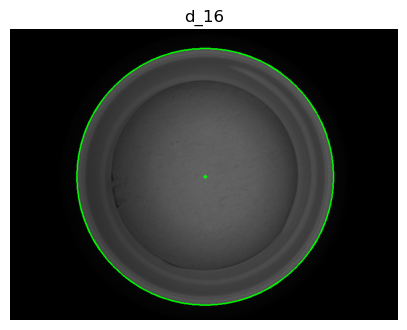

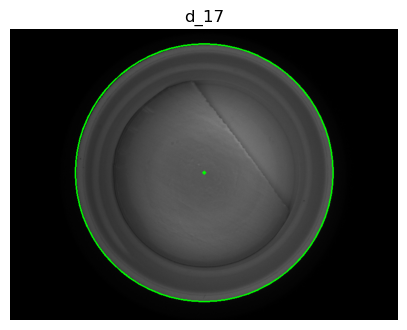

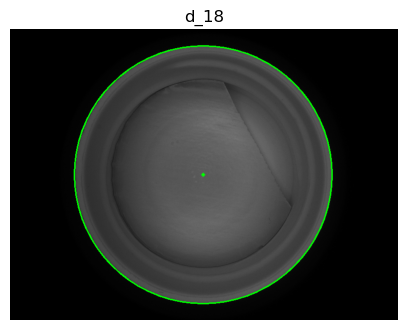

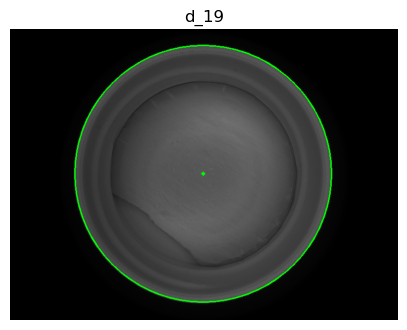

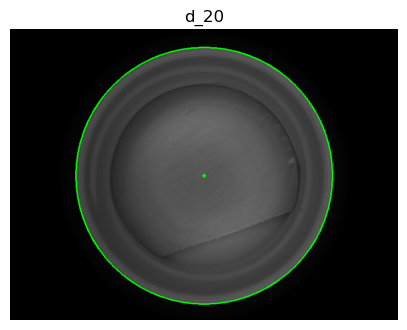

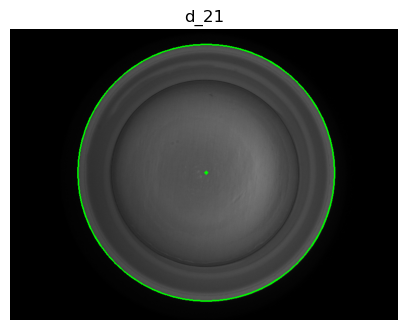

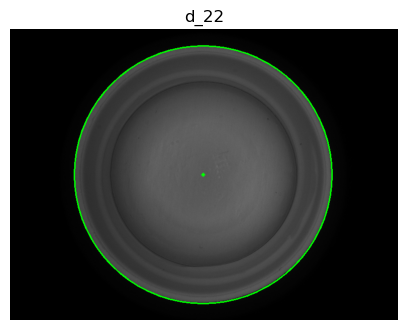

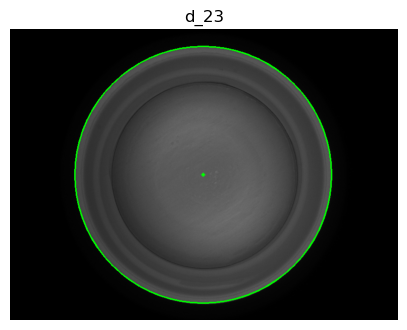

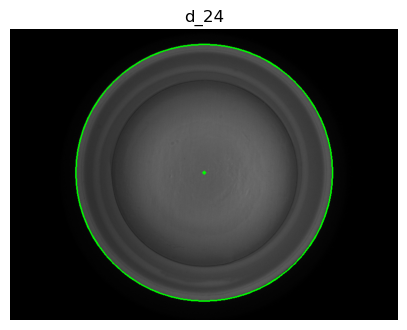

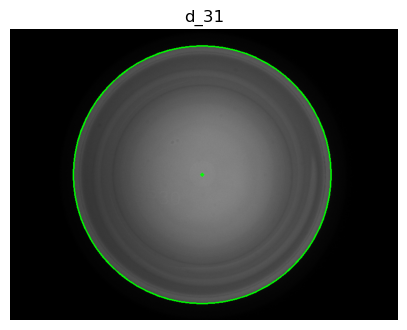

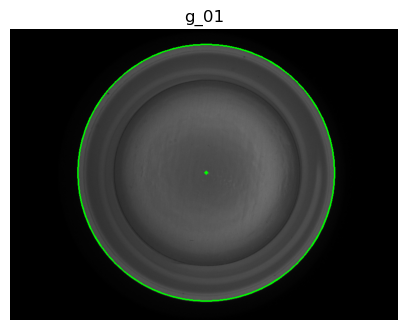

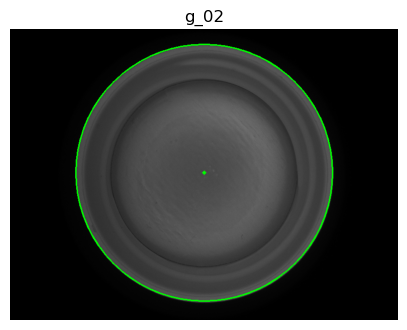

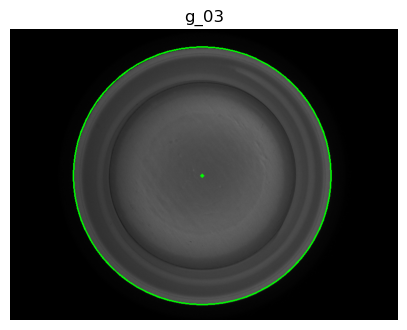

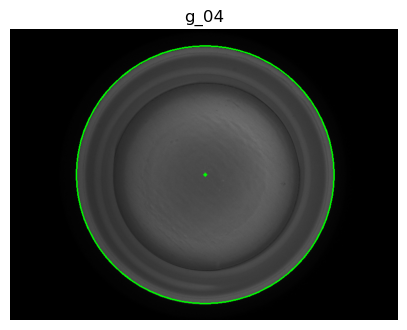

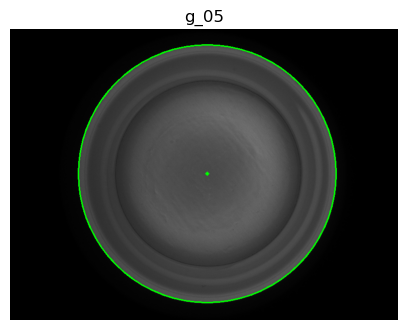

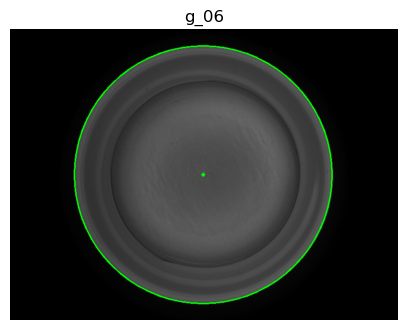

In [3]:
for entry in file_list:
    img = cv2.imread(str(entry))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    circles = find_circle(img_gray, 100, 100)
    img = draw_circles(img, circles)
    show_image(img, str(entry.stem))

### Find Defects

We can notice that the mean of the image in grayscale is similar in all the images except from the ones without the liner. So we can use this value to find if the liner is present or not.
To find if there are defects in the liner, first we need to mask out everything except the liner. To do so, we can use the Hough Transform with lower parameters and using the maximum radius (to avoid to find the cap circle). 

Then we can use the Canny Edge Detector to find the edges of the liner. To get stronger edges we dilatate the results. Finally to find the defects we can use again the Hough Transform but this time to find lines.

Opencv provides a function called HoughLinesP to find lines in an image.
The function express lines in the Polar form (rho, theta).
For any point in the image (x,y) it looks for all the lines that pass through that point and for each we get a sinusoid. If the curves of two different points intersect, this mean that both points belong to a same line. So we can detect the lines by looking for the intersection of the curves and return the lines that have intersection above a certain threshold.
Finally the HoughLinesP function return the lines in the Cartesian form (x1,y1,x2,y2).

If there is a line in the image we consider it as a defect.

In [4]:
def get_circle_mask(img, circle, ratio=1.):
    """
        Get mask of circle in image

        Parameters
        ----------
        img : numpy.ndarray
            Image to get circle mask from
        circle : numpy.ndarray
            Circle to get mask from (x, y, r)
        ratio : float
            Ratio of circle to get mask from (1. = full circle, 0. = no circle)
        
        Returns
        -------
        mask : numpy.ndarray
            Mask of circle in image
    """
    mask = np.zeros(img.shape, dtype=np.uint8)
    circle = np.uint16(np.around(circle))
    mask = cv2.circle(mask, (circle[0], circle[1]), int(circle[2]*ratio), (255, 255, 255), -1)
    return mask

def mask_circle(img, circle):
    """
        Mask circle in image

        Parameters
        ----------
        img : numpy.ndarray
            Image to mask circle in
        circle : numpy.ndarray
            Circle to mask (x, y, r)
        
        Returns
        -------
        masked_img : numpy.ndarray
            Image with circle masked
    """
    mask = get_circle_mask(img, circle, .92)
    img[mask == 0] = 0
    return img
def is_liner_present(img, circle, threshold=80):
    """
        Check if liner is present in image

        Parameters
        ----------
        img : numpy.ndarray
            Image to check for liner
        circle : numpy.ndarray
            Circle to check for liner in (x, y, r)
        threshold: int
            Threshold for liner detection (Over threshold mean no liner)
        Returns
        -------
        is_liner_present : bool
            True if liner is present, False otherwise
    """
    mask = get_circle_mask(img, circle)

    # Consider only the actual cap (everything inside the circle)

    return np.mean(img[mask == 255]) < threshold

def draw_lines(img, lines, color=(0, 255, 0)):
    """
        Draw lines on image
        
        Parameters
        ----------
        img : numpy.ndarray
            Image to draw lines on
        lines : numpy.ndarray
            Array of lines to draw on image
    """
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(img, (x1, y1), (x2, y2), color, 2)
    return img

def is_defected(img, circle):
    """
        Check if cap is defected

        Parameters
        ----------
        img : numpy.ndarray
            Image to check for defects
        circle : numpy.ndarray
            Cut the cap a bit smaller than the liner
        Returns
        -------
        is_defected : bool
            True if cap is defected, False otherwise
        lines : numpy.ndarray
            Defects f
    """
    img = mask_circle(img, circle)

    edge = cv2.Canny(img, 50, 50, apertureSize=3)
    # show_image(edge, 'edge')
    dilatate = cv2.dilate(edge, np.ones((3, 3), np.uint8), iterations=1)

    lines = cv2.HoughLinesP(dilatate, 1, np.pi / 180, 100, minLineLength=60, maxLineGap=30)
    defected = lines is not None and len(lines) > 0
    return defected, lines


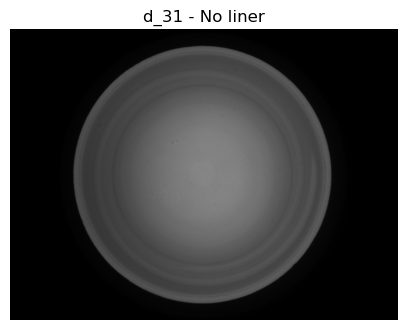

In [5]:
for entry in file_list:
    img = cv2.imread(str(entry))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    circles = find_circle(img_gray, 100, 100)
    outer_circle = circles[0][0]
    # print(entry.stem + " mean = ", end=' ')
    liner = is_liner_present(img_gray, outer_circle)
    if not liner:
        show_image(img, entry.stem + " - No liner")

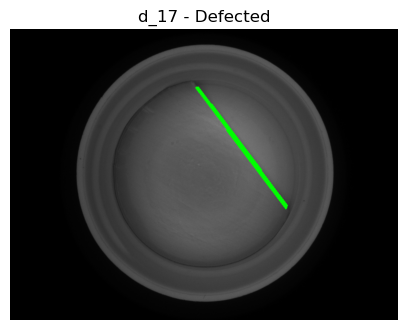

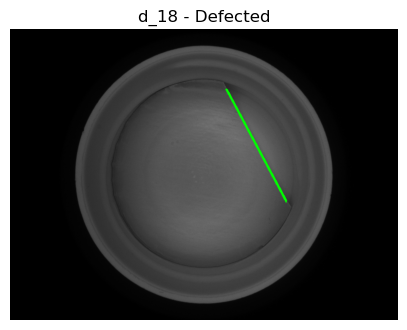

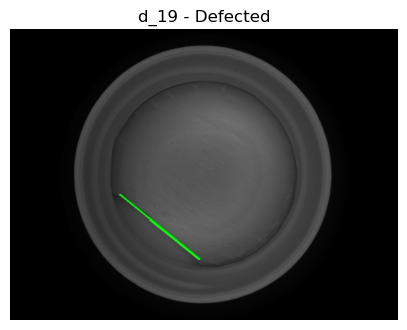

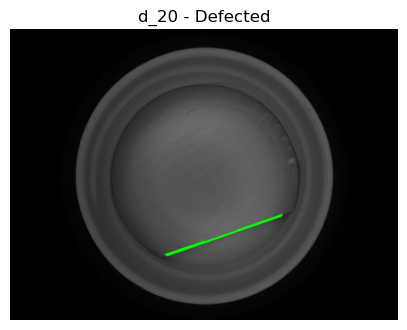

In [6]:
for entry in file_list:
    img = cv2.imread(str(entry))
    img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    circles = find_circle(img_gray, 100, 100)
    outer_circle = circles[0][0]
    # print(entry.stem + " mean = ", end=' ')
    liner = is_liner_present(img_gray, outer_circle)
    if not liner:
        continue
    circles = find_circle(img_gray, 50, 50, maxRadius=200)
    inner_circle = circles[0][0]

    defected, lines = is_defected(img_gray, inner_circle)
    
    if defected:
        img = draw_lines(img, lines)
        show_image(img, entry.stem + " - Defected")

    

## Second Task
The second task consists in outlining the liner of the cap if it is present.

### Find Liner Circles
To find the liner circles we can use the Hough Transform with lower parameters and using the maximum radius (to avoid to find the cap circle).

Now we can put all together and find the defects in the liner of the cap.

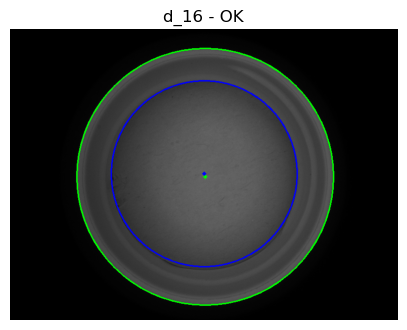

Cap - Center: (385.50,291.50), Diameter: 508.00
Liner - Center: (384.50,286.50), Diameter: 368.80


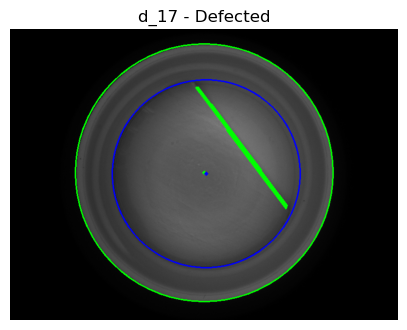

Cap - Center: (384.50,283.50), Diameter: 509.60
Liner - Center: (387.50,286.50), Diameter: 371.00
Liner is incomplete


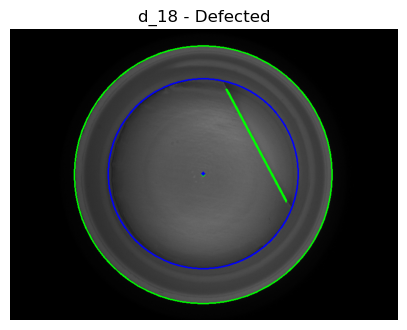

Cap - Center: (382.50,287.50), Diameter: 510.20
Liner - Center: (382.50,285.50), Diameter: 375.60
Liner is incomplete


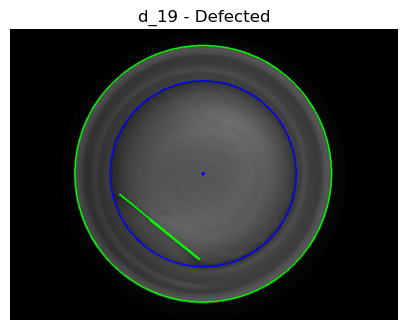

Cap - Center: (381.50,285.50), Diameter: 507.60
Liner - Center: (382.50,286.50), Diameter: 368.80
Liner is incomplete


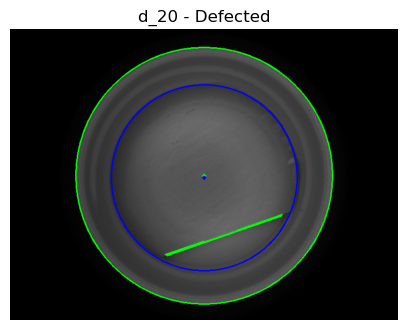

Cap - Center: (384.50,290.50), Diameter: 507.80
Liner - Center: (383.50,293.50), Diameter: 369.00
Liner is incomplete


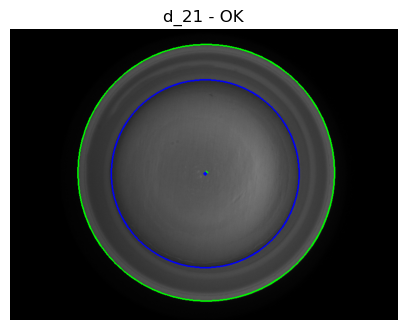

Cap - Center: (387.50,284.50), Diameter: 507.60
Liner - Center: (385.50,285.50), Diameter: 371.80


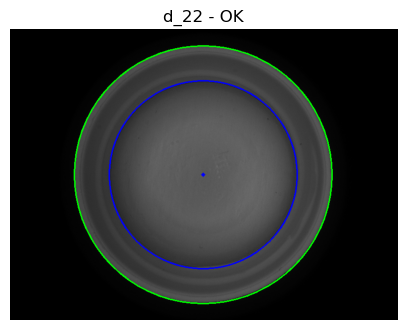

Cap - Center: (381.50,288.50), Diameter: 509.20
Liner - Center: (382.50,288.50), Diameter: 371.00


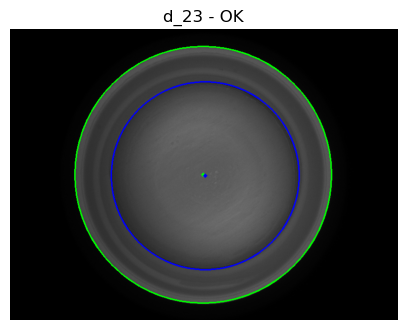

Cap - Center: (382.50,288.50), Diameter: 509.00
Liner - Center: (385.50,289.50), Diameter: 371.40


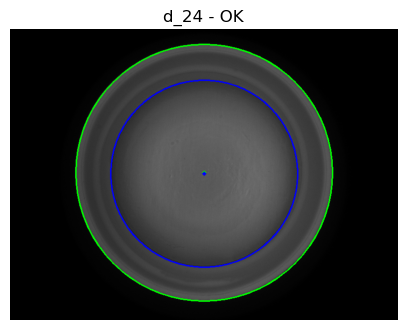

Cap - Center: (383.50,283.50), Diameter: 508.40
Liner - Center: (384.50,285.50), Diameter: 370.40


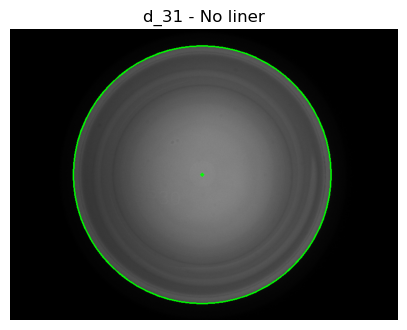

Cap - Center: (379.50,287.50), Diameter: 510.00
Liner is missing


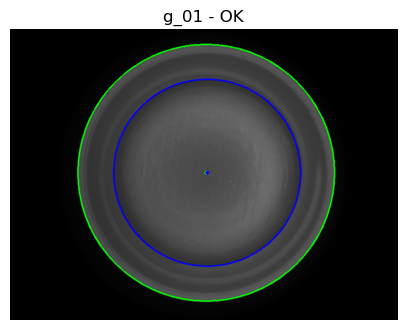

Cap - Center: (387.50,284.50), Diameter: 509.00
Liner - Center: (390.50,284.50), Diameter: 369.60


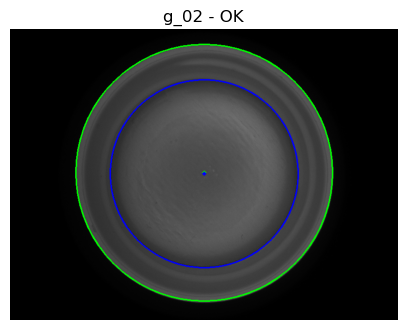

Cap - Center: (384.50,284.50), Diameter: 508.60
Liner - Center: (384.50,286.50), Diameter: 371.20


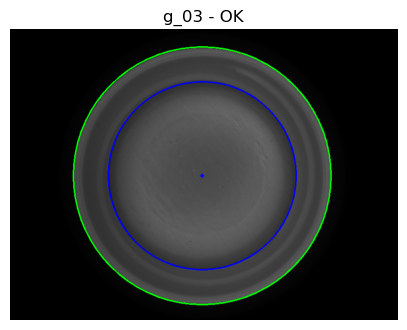

Cap - Center: (380.50,290.50), Diameter: 510.20
Liner - Center: (379.50,290.50), Diameter: 371.60


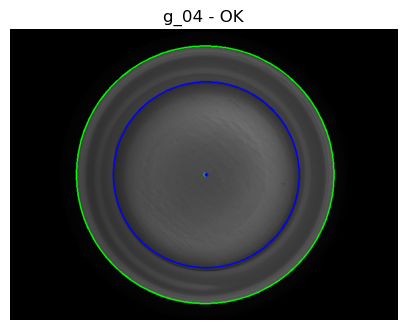

Cap - Center: (385.50,288.50), Diameter: 510.00
Liner - Center: (387.50,288.50), Diameter: 368.20


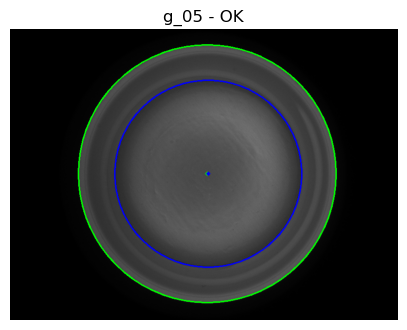

Cap - Center: (390.50,286.50), Diameter: 509.60
Liner - Center: (392.50,285.50), Diameter: 370.00


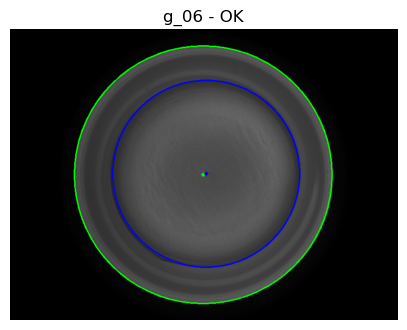

Cap - Center: (382.50,287.50), Diameter: 509.80
Liner - Center: (388.50,286.50), Diameter: 370.40


In [9]:
for entry in file_list:
    img = cv2.imread(str(entry))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)



    circles = find_circle(gray, 100, 100)
    outer_circle = circles[0][0]

    img = draw_circles(img, circles)
    liner = is_liner_present(gray, outer_circle)
    if not liner:
        show_image(img, entry.stem + " - No liner")
        print("Cap - Center: ({:.2f},{:.2f}), Diameter: {:.2f}".format(outer_circle[0], outer_circle[1], outer_circle[2] * 2))
        print("Liner is missing")
        continue
    circles = find_circle(gray, 50, 50, maxRadius=200)
    img = draw_circles(img, circles, color=(0, 0, 255))
    inner_circle = circles[0][0]

    defected, lines = is_defected(gray, inner_circle)
    title = entry.stem + " - Defected" if defected else entry.stem + " - OK"
    
    img = draw_lines(img, lines)
    # plt.figure(figsize=(10, 10))
    show_image(img, title)
    print("Cap - Center: ({:.2f},{:.2f}), Diameter: {:.2f}".format(outer_circle[0], outer_circle[1], outer_circle[2] * 2))
    print("Liner - Center: ({:.2f},{:.2f}), Diameter: {:.2f}".format(inner_circle[0], inner_circle[1], inner_circle[2] * 2))
    if defected:
        print("Liner is incomplete")